# Ищем мусор на побережье Камчатки по фоткам с дрона

Мы обучили бейзлайн-модель для поиска и сегментации мусора. Она была обучена на смеси датасета, который предоставлен вам как обучающий и на наших дополнительных данных.
Этот пример предназначен только для того, чтобы продемонстрировать как собрать данные для отправки, вы не обязаны использовать архитектуру/фреймворк/whatsoever. Более того, так как у вас нет наших весов и части функций, этот пример невозможно будет просто взять и завести на вашей машине, модель придется менять.

### Импорты, функции

In [1]:
import torch, torchvision

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
import numpy as np
import os, json, cv2, random, yaml

In [4]:
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import default_setup

In [6]:
def setup(path_to_subconfig, load_from_checkpoint=None):
    """
    Create configs and perform basic setups.
    """

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    
    cfg.MODEL.BACKBONE.IN_CHANNELS = None
    cfg.MODEL.BACKBONE.NUM_CLASSES = None
    cfg.MODEL.BACKBONE.TYPE = None
    cfg.merge_from_file(path_to_subconfig)

    if load_from_checkpoint is not None:
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(load_from_checkpoint)

    default_setup(cfg, None)
    return cfg

In [7]:
from skimage.io import imread

In [8]:
def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []
        ran = C if isinstance(C, list) else range(C)
        for i in ran:
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / float(union))
        ious.append(iou)
    ious = [np.mean(iou) for iou in zip(*ious)] # mean accross images if per_image
    return 100 * np.array(ious)

def get_iou(preds, labels, label_to_calculate=None):
    C = preds.shape[1]
    preds = torch.argmax(preds, 1)
    if label_to_calculate is not None:
        return iou(preds, labels[:, 0], [label_to_calculate,]).mean()
    else:
        return iou(preds, labels[:, 0], C)[1:].mean() # ignoiring background label.

### Конфигурируем модель и параметры датасета

In [9]:
cfg = setup('detectron_config.yaml', 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml')

WARNING [12/03 20:38:45 d2.config.compat]: Config 'detectron_config.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[12/03 20:38:45 detectron2]: Rank of current process: 0. World size: 1
[12/03 20:38:45 detectron2]: Rank of current process: 0. World size: 1
[12/03 20:38:46 detectron2]: Environment info:
----------------------  ------------------------------------------------------------------------
sys.platform            linux
Python                  3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0]
numpy                   1.17.0
detectron2              0.5 @/home/ws/tb0536/anaconda3/lib/python3.7/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.7.1 @/home/ws/tb0536/anaconda3/lib/python3.7/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0,1                 Quadro RTX 8000 (a

In [10]:
MetadataCatalog.get("waste").set(thing_classes=['metall', 'net', 'plastic', 'wood'])
waste_metadata = MetadataCatalog.get("waste")

Критично важная функция для отправки своих результатов: Run Length Encoding масок.

In [11]:
def rle(inarray):
    """ run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) """
    ia = np.asarray(inarray)                # force numpy
    n = len(ia)
    if n == 0: 
        return (None, None, None)
    else:
        y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)   # must include last element posi
        z = np.diff(np.append(-1, i))       # run lengths
        p = np.cumsum(np.append(0, z))[:-1] # positions
        return(z, p, ia[i])

def rlencode_mask(mask):
    l,s,v = rle(mask.flatten()) # length, starts, values
    l,s = l[v], s[v]
    encoded = ' '.join([' '.join(map(str, e)) for e in zip(s, l)])
    if not encoded:
        encoded = '0 0'
    return encoded

### Грузим веса, инициализируем инференс-класс

In [12]:
cfg.MODEL.WEIGHTS = "model_final.pth" # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/03 20:38:53 fvcore.common.checkpoint]: [Checkpointer] Loading from model_final.pth ...


### Просматриваем, тестируем и формируем посылку
Ниже три секции, которые делают следующее:
1. Просто визуализирует результаты
2. Визуализирует на два фрейма предсказанную и истинную маски для отладки, показывает IoU скор по классам. (Он не равен Dice но они тесно связаны).
3. Формирует csv файл посылки.

Критично важной для вас является только третья ячейка, остальные оставлены здесь, для возможности визуальной оценки работы предложенного бейзлайна.

In [13]:
data_folder = '../waste/data/razmetka_1km/'

/home/ws/tb0536/anaconda3/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


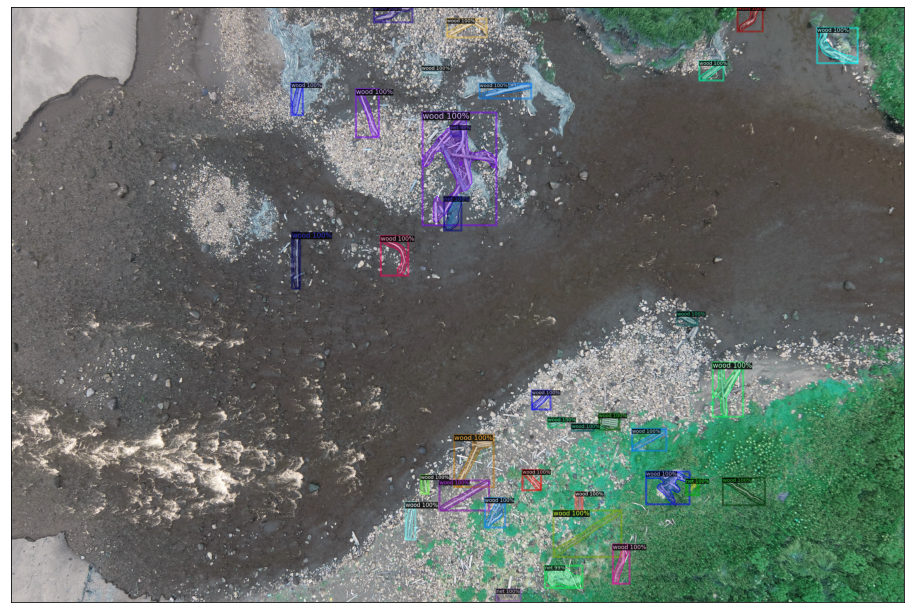

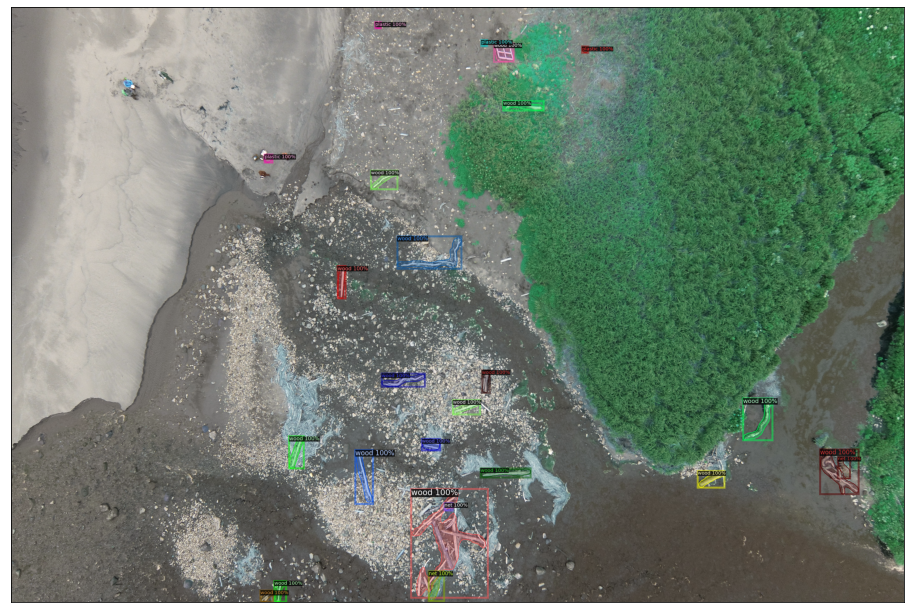

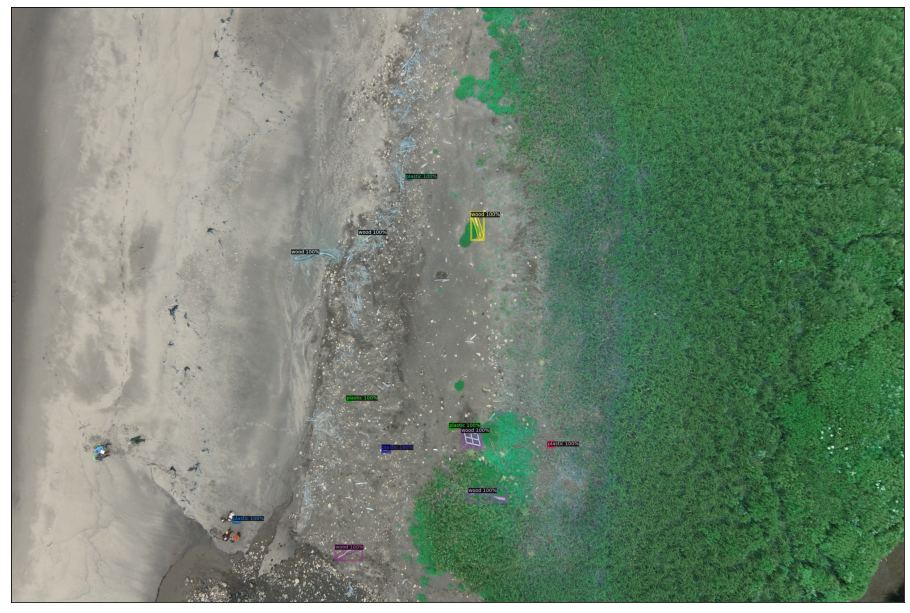

In [14]:
for i in range(0, 3):
    im = cv2.imread(os.path.join(data_folder, f'{i:02}_image.JPG')) 
    outputs = predictor(im)  
    v = Visualizer(im[:, :, ::-1],
                   metadata=waste_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(16, 16))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

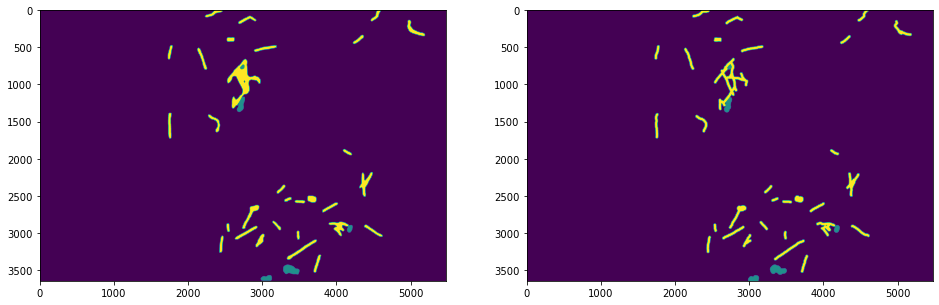

[100.          88.01845039 100.          80.11442441]


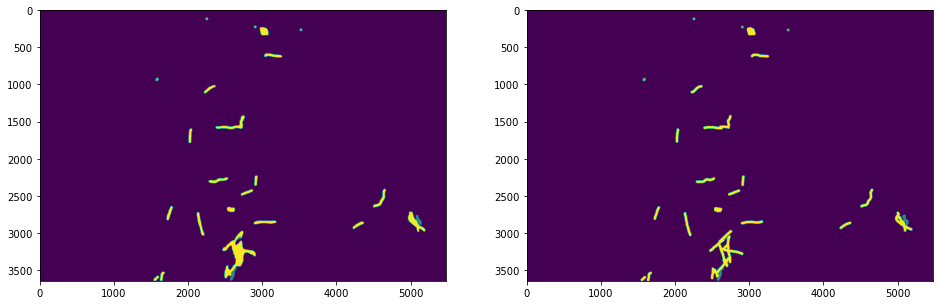

[100.          79.77005008  86.48542159  80.80302516]


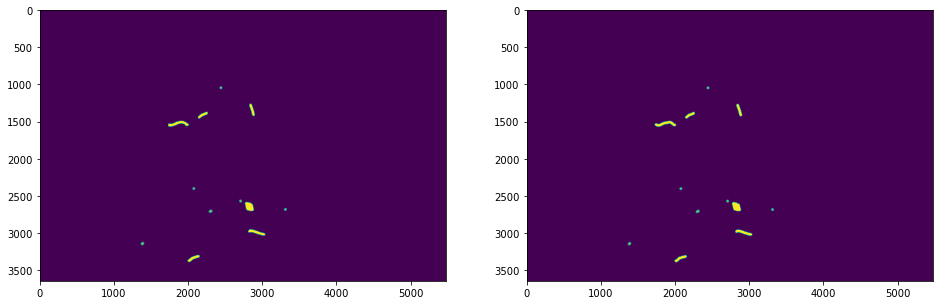

[100.         100.          86.94964408  89.31303825]


In [17]:
for i in tqdm(range(0, 3)):
    im = cv2.imread(os.path.join(data_folder, f'{i:02}_image.JPG'))  
    outputs = predictor(im)
    
    predicted_mask = np.zeros(im.shape[:-1], np.uint8)
    for c, m in zip(outputs['instances'].pred_classes.detach().cpu().numpy(), 
                    outputs['instances'].pred_masks.detach().cpu().numpy()):
        predicted_mask[m] = c+1
    
    expected_mask = np.zeros(im.shape[:-1], np.uint8)
    for class_id, class_name in enumerate(waste_metadata.thing_classes, start=1):
        addr = os.path.join(data_folder, f'{i:02}_{class_name}.png')
        if os.path.exists(addr):
            img = imread(addr)
            mask = (img.sum(-1) > 0)
            expected_mask[mask] = class_id
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,10))
    ax1.imshow(predicted_mask)
    ax2.imshow(expected_mask)
    plt.show()
    print(iou(predicted_mask, expected_mask, C=[1,2,3,4]))

In [16]:
lines = ['Type_Id,Mask\n']
for i in tqdm(range(0, 32)):
    im = cv2.imread(os.path.join(data_folder, f'{i:02}_image.JPG'))
    outputs = predictor(im)
    predicted_mask = np.zeros(im.shape[:-1], np.uint8)
    for c, m in zip(outputs['instances'].pred_classes.detach().cpu().numpy(), 
                    outputs['instances'].pred_masks.detach().cpu().numpy()):
        predicted_mask[m] = c+1
    for class_id, class_name in enumerate(waste_metadata.thing_classes, start=1):
        encoded = f'{class_name}_{i},' + rlencode_mask(predicted_mask == class_id) + f'\n'
        lines.append(encoded)

with open('baseline_solution.csv', 'w') as f:
    f.writelines(lines)

  0%|          | 0/32 [00:00<?, ?it/s]